# Loading CSV and airport directory

In [2]:
import pandas as pd

# Loading route data
df_2019 = pd.read_csv('full_2019.csv')
df_2024 = pd.read_csv('full_2024.csv')

print("Number of routes in 2019:", len(df_2019))
print("Number of routes in 2024:", len(df_2024))


# Downloading airport directory from GitHub
url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat'
columns = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO',
           'Latitude', 'Longitude', 'Altitude', 'Timezone',
           'DST', 'TzDB', 'Type', 'Source']
airports_raw = pd.read_csv(url, header=None, names=columns, dtype=str)
airports_raw = airports_raw[airports_raw['ICAO'].notnull() & (airports_raw['ICAO'] != '\\N')]

print("Number of airports:", len(airports_raw))

Number of routes in 2019: 82482
Number of routes in 2024: 138929
Number of airports: 7697


In [3]:
# /// Filtering by region of interest (Eastern Europe and CIS countries)
region_countries = [
    "Russia", "Ukraine", "Belarus", "Poland", "Romania", "Moldova", "Bulgaria",
    "Turkey", "Georgia", "Armenia", "Azerbaijan", "Kazakhstan", "Hungary",
    "Slovakia", "Czech Republic", "Serbia", "Croatia", "Latvia", "Lithuania",
    "Estonia", "Bosnia and Herzegovina", "North Macedonia", "Albania", "Slovenia"
]

regional_airports = airports_raw[airports_raw['Country'].isin(region_countries)]
regional_icao_set = set(regional_airports['ICAO'])
print("Number of airports in the region:", len(regional_airports))

def filter_region(df):
    return df[
        (df['estdepartureairport'].isin(regional_icao_set)) |
        (df['estarrivalairport'].isin(regional_icao_set))
    ]

df_2019_regional = filter_region(df_2019)
df_2024_regional = filter_region(df_2024)
print("Number of routes in 2019:", len(df_2019_regional))
print("Number of routes in 2024:", len(df_2024_regional))

Number of airports in the region: 622
Number of routes in 2019: 4863
Number of routes in 2024: 6267


In [4]:
# /// Statistics on the number of flights and routes
print("2019 average flights per route:", df_2019_regional['flights'].mean())
print("2024 average flights per route:", df_2024_regional['flights'].mean())
print("Top 10 routes in 2019:")
print(df_2019_regional.sort_values(by='flights', ascending=False).head(10))
print("Top 10 routes in 2024:")
print(df_2024_regional.sort_values(by='flights', ascending=False).head(10))

2019 average flights per route: 4.738227431626568
2024 average flights per route: 4.9109621828626135
Top 10 routes in 2019:
      estdepartureairport estarrivalairport  flights
8731                 ULLI              UUEE      165
36785                ULLI              UUWW      122
35211                LTAC              LTFJ      110
14821                UUEE              UUEE      107
72153                LTAC              LTBW      106
1554                 LTFJ              LTAC      100
63907                ULLI              UUDD       89
43357                UUEE              ULLI       79
80055                UUEE              ULLP       75
1066                 LTFJ              LTFE       73
Top 10 routes in 2024:
       estdepartureairport estarrivalairport  flights
108659                LTFM              LTFM       71
133468                EFHK              EETN       69
4614                  EETN              EFHK       69
9563                  LTFJ              LTCG       68


In [5]:
# /// Filtering strong routes (3+ flights)
df_2019_strong = df_2019_regional[df_2019_regional['flights'] >= 3]
df_2024_strong = df_2024_regional[df_2024_regional['flights'] >= 3]

strong_2019_routes = set(zip(df_2019_strong['estdepartureairport'], df_2019_strong['estarrivalairport']))
strong_2024_routes = set(zip(df_2024_strong['estdepartureairport'], df_2024_strong['estarrivalairport']))
common_strong = strong_2019_routes & strong_2024_routes


print("Number of strong routes in 2019:", len(strong_2019_routes))
print("Number of strong routes in 2024:", len(strong_2024_routes))
print("Number of common strong routes:", len(common_strong))

Number of strong routes in 2019: 2043
Number of strong routes in 2024: 2723
Number of common strong routes: 843


# Building graphs and calculating metrics

In [6]:
# /// Building graphs and calculating metricsimport networkx as nx
import networkx as nx

def build_weighted_graph(df):
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row['estdepartureairport'], row['estarrivalairport'], weight=row['flights'])
    return G

G_2019_strong = build_weighted_graph(df_2019_strong)
G_2024_strong = build_weighted_graph(df_2024_strong)

def calculate_metrics(G):
    pagerank = nx.pagerank(G, weight='weight')
    betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
    in_degree = dict(G.in_degree(weight='weight'))
    out_degree = dict(G.out_degree(weight='weight'))

    df = pd.DataFrame({
        'PageRank': pd.Series(pagerank),
        'Betweenness': pd.Series(betweenness),
        'InDegree': pd.Series(in_degree),
        'OutDegree': pd.Series(out_degree)
    })

    df['TotalDegree'] = df['InDegree'] + df['OutDegree']
    return df.sort_values(by='PageRank', ascending=False)

metrics_2019 = calculate_metrics(G_2019_strong)
metrics_2024 = calculate_metrics(G_2024_strong)

print(metrics_2019.head(5))
print(metrics_2024.head(5))

      PageRank  Betweenness  InDegree  OutDegree  TotalDegree
UUEE  0.058987     0.054899      1582       1666         3248
EPWA  0.035487     0.069865       892        934         1826
LTFJ  0.031253     0.059120       812        867         1679
LKVO  0.029541     0.033427       788         31          819
EVRA  0.026980     0.057569       652        642         1294
      PageRank  Betweenness  InDegree  OutDegree  TotalDegree
LTFM  0.069911     0.166727      1678       1986         3664
EPWA  0.042654     0.048065      1527       1562         3089
LTAI  0.029340     0.093500      1022        971         1993
LKPR  0.028429     0.064636      1058       1095         2153
LTFJ  0.027160     0.041866       963       1041         2004


In [7]:
# /// Data enrichment with airport information
def enrich_info(icao):
    row = airports_raw[airports_raw['ICAO'] == icao]
    if not row.empty:
        return pd.Series({'Airport': row.iloc[0]['Name'], 'Country': row.iloc[0]['Country']})
    return pd.Series({'Airport': 'Unknown', 'Country': 'Unknown'})

metrics_2019 = metrics_2019.copy()
metrics_2024 = metrics_2024.copy()

metrics_2019[['Airport', 'Country']] = metrics_2019.index.to_series().apply(enrich_info)
metrics_2024[['Airport', 'Country']] = metrics_2024.index.to_series().apply(enrich_info)

In [8]:
# /// Compare PageRank values between 2019 and 2024
import matplotlib.pyplot as plt

# Merge PageRank values
pagerank_compare = metrics_2019[['PageRank']].rename(columns={'PageRank': 'PageRank_2019'}).join(
    metrics_2024[['PageRank']].rename(columns={'PageRank': 'PageRank_2024'}), how='outer'
).fillna(0)

pagerank_compare['PageRank_Delta'] = pagerank_compare['PageRank_2024'] - pagerank_compare['PageRank_2019']

# Enrich with airport metadata
def enrich_info(icao):
    row = airports_raw[airports_raw['ICAO'] == icao]
    if not row.empty:
        return pd.Series({'Airport': row.iloc[0]['Name'], 'Country': row.iloc[0]['Country']})
    return pd.Series({'Airport': 'Unknown', 'Country': 'Unknown'})

enriched = pagerank_compare.index.to_series().apply(enrich_info)
pagerank_compare = pd.concat([pagerank_compare, enriched], axis=1)

# Sort and preview
pagerank_sorted = pagerank_compare.sort_values(by='PageRank_Delta', ascending=False)
display(pagerank_sorted.head(30))

,PageRank_2019,PageRank_2024,PageRank_Delta,Airport,Country
LTFM,0.000000,0.069911,0.069911,Istanbul Airport,Turkey
LTAI,0.000000,0.029340,0.029340,Antalya International Airport,Turkey
LKPR,0.000873,0.028429,0.027556,Václav Havel Airport Prague,Czech Republic
LYBE,0.005532,0.020905,0.015372,Belgrade Nikola Tesla Airport,Serbia
LROP,0.007240,0.022099,0.014860,Henri Coandă International Airport,Romania
LBSF,0.000000,0.012682,0.012682,Sofia Airport,Bulgaria
LTBL,0.000000,0.007353,0.007353,Çiğli Airport,Turkey
EPWA,0.035487,0.042654,0.007167,Warsaw Chopin Airport,Poland
LHBP,0.018979,0.026007,0.007028,Budapest Liszt Ferenc International Airport,Hungary
LKKU,0.000000,0.006042,0.006042,Kunovice Airport,Czech Republic


In [9]:
print("🔝 2019 — Top 20 airports by PageRank:")
display(metrics_2019.head(10))

print("\n🔝 2024 — Top 20 airports by PageRank:")
display(metrics_2024.head(10))

🔝 2019 — Top 20 airports by PageRank:


,PageRank,Betweenness,InDegree,OutDegree,TotalDegree,Airport,Country
UUEE,0.058987,0.054899,1582,1666,3248,Sheremetyevo International Airport,Russia
EPWA,0.035487,0.069865,892,934,1826,Warsaw Chopin Airport,Poland
LTFJ,0.031253,0.059120,812,867,1679,Sabiha Gökçen International Airport,Turkey
LKVO,0.029541,0.033427,788,31,819,Vodochody Airport,Czech Republic
EVRA,0.026980,0.057569,652,642,1294,Riga International Airport,Latvia
UUWW,0.020982,0.102160,453,464,917,Vnukovo International Airport,Russia
UUDD,0.019718,0.049392,546,572,1118,Domodedovo International Airport,Russia
LHBP,0.018979,0.044607,513,916,1429,Budapest Liszt Ferenc International Airport,Hungary
UKBB,0.018206,0.032244,511,537,1048,Boryspil International Airport,Ukraine
EPKK,0.017213,0.038334,406,393,799,Kraków John Paul II International Airport,Poland



🔝 2024 — Top 20 airports by PageRank:


,PageRank,Betweenness,InDegree,OutDegree,TotalDegree,Airport,Country
LTFM,0.069911,0.166727,1678,1986,3664,Istanbul Airport,Turkey
EPWA,0.042654,0.048065,1527,1562,3089,Warsaw Chopin Airport,Poland
LTAI,0.029340,0.093500,1022,971,1993,Antalya International Airport,Turkey
LKPR,0.028429,0.064636,1058,1095,2153,Václav Havel Airport Prague,Czech Republic
LTFJ,0.027160,0.041866,963,1041,2004,Sabiha Gökçen International Airport,Turkey
LHBP,0.026007,0.057134,981,1018,1999,Budapest Liszt Ferenc International Airport,Hungary
LROP,0.022099,0.035659,808,836,1644,Henri Coandă International Airport,Romania
LYBE,0.020905,0.047057,683,694,1377,Belgrade Nikola Tesla Airport,Serbia
EPKK,0.017019,0.066614,617,623,1240,Kraków John Paul II International Airport,Poland
EPGD,0.014078,0.033790,447,461,908,Gdańsk Lech Wałęsa Airport,Poland


 # Visualizations

<ipython-input-12-51fde2563849>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_gain['Label'] = top_gain['Airport'] + " (" + top_gain['Country'] + ")"
<ipython-input-12-51fde2563849>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PageRank_Delta', y='Label', data=top_gain, ax=axes[0], palette='Greens_r')
<ipython-input-12-51fde2563849>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PageRank_Delta', y='Label', data=top_loss, ax=axes[1

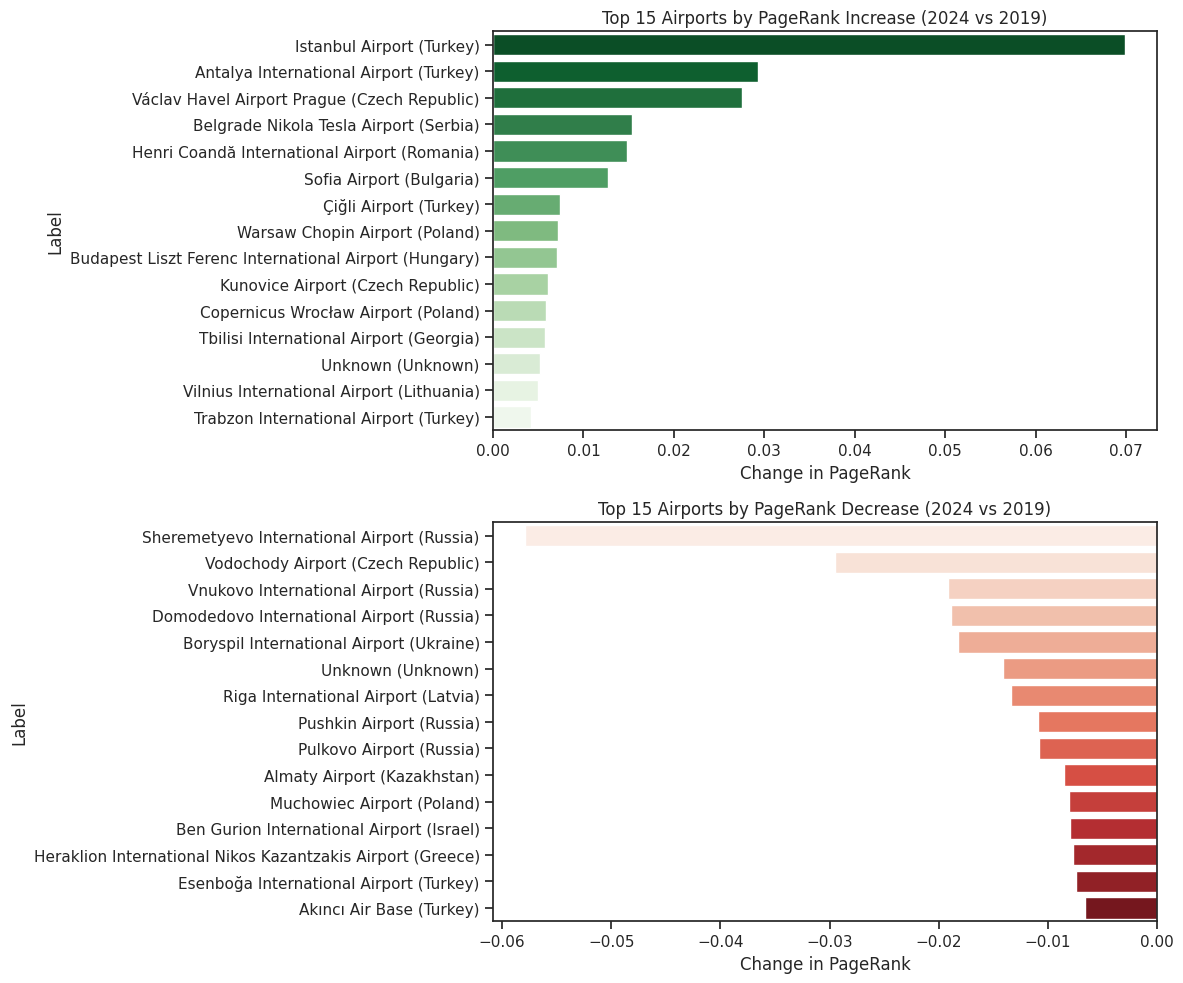

In [12]:
# /// Plot PageRank delta with barplots
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="ticks")

top_gain = pagerank_sorted.head(15)
top_loss = pagerank_sorted.sort_values(by='PageRank_Delta').head(15)

top_gain['Label'] = top_gain['Airport'] + " (" + top_gain['Country'] + ")"
top_loss['Label'] = top_loss['Airport'] + " (" + top_loss['Country'] + ")"

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.barplot(x='PageRank_Delta', y='Label', data=top_gain, ax=axes[0], palette='Greens_r')
axes[0].set_title("Top 15 Airports by PageRank Increase (2024 vs 2019)")
axes[0].set_xlabel("Change in PageRank")

sns.barplot(x='PageRank_Delta', y='Label', data=top_loss, ax=axes[1], palette='Reds')
axes[1].set_title("Top 15 Airports by PageRank Decrease (2024 vs 2019)")
axes[1].set_xlabel("Change in PageRank")

plt.tight_layout()
plt.show()

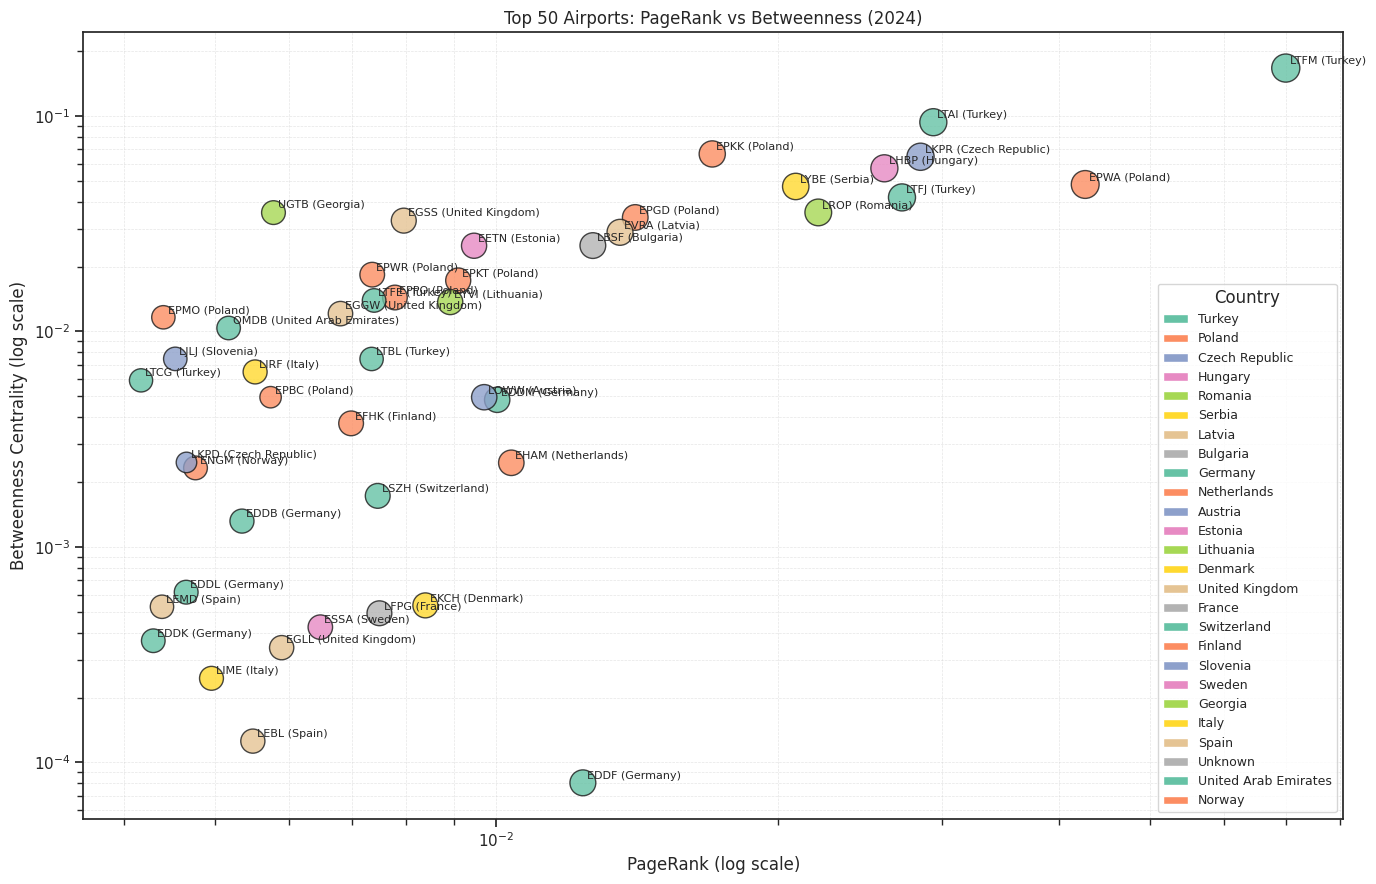

In [13]:
# /// Scatter plot of PageRank vs Betweenness (log scale)
import numpy as np
from matplotlib.patches import Patch

df_plot = metrics_2024.copy()

if 'Country' not in df_plot.columns:
    df_plot = df_plot.reset_index()
    df_plot = df_plot.merge(
        airports_raw[['ICAO', 'Country']],
        left_on='index', right_on='ICAO', how='left'
    )
    df_plot = df_plot.set_index('index')

top_n = 50
df_top = df_plot.sort_values(by='PageRank', ascending=False).head(top_n)

sns.set_theme(style="ticks", palette="Set2")

# Assign colors by country
unique_countries = df_top['Country'].unique()
palette = sns.color_palette("Set2", len(unique_countries))
country_color = dict(zip(unique_countries, palette))
df_top['Color'] = df_top['Country'].map(country_color)

# Scatter plot
plt.figure(figsize=(14, 9))
plt.scatter(
    df_top['PageRank'],
    df_top['Betweenness'],
    s=np.log1p(df_top['TotalDegree']) * 50,
    c=df_top['Color'],
    alpha=0.8,
    edgecolors='k'
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("PageRank (log scale)")
plt.ylabel("Betweenness Centrality (log scale)")
plt.title("Top 50 Airports: PageRank vs Betweenness (2024)")

for i, row in df_top.iterrows():
    plt.annotate(
        f"{i} ({row['Country']})",
        (row['PageRank'], row['Betweenness']),
        fontsize=8,
        xytext=(3, 3),
        textcoords='offset points'
    )

legend_elements = [Patch(facecolor=country_color[c], label=c) for c in unique_countries]
plt.legend(handles=legend_elements, title="Country", loc="lower right", fontsize=9)

plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig("pagerank_vs_betweenness_log_scaled.png", dpi=300)
plt.show()

<ipython-input-14-25da5815fc4a>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pr_by_country.values, y=pr_by_country.index, palette='Blues_r')


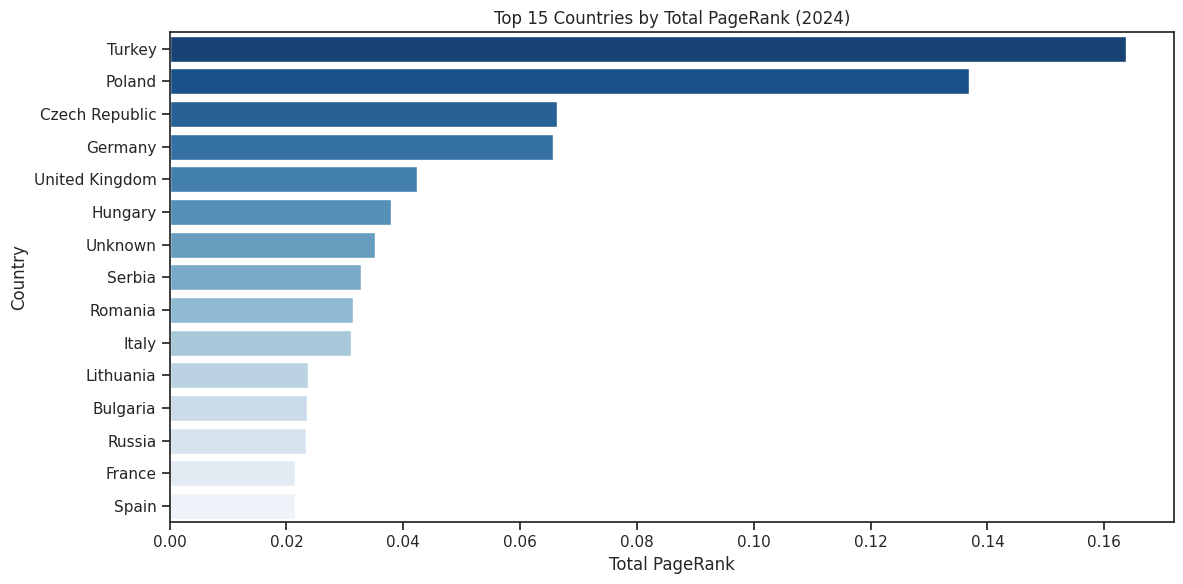

In [14]:
# /// Country-level total PageRank barplot (fix)
country_pr = metrics_2024.copy().reset_index()

# If 'Country' column not in dataframe — add it
if 'Country' not in country_pr.columns:
    country_pr = country_pr.merge(
        airports_raw[['ICAO', 'Country']], left_on='index', right_on='ICAO', how='left'
    )

# Now group and plot
pr_by_country = country_pr.groupby('Country')['PageRank'].sum().sort_values(ascending=False).head(15)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=pr_by_country.values, y=pr_by_country.index, palette='Blues_r')
plt.title("Top 15 Countries by Total PageRank (2024)")
plt.xlabel("Total PageRank")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

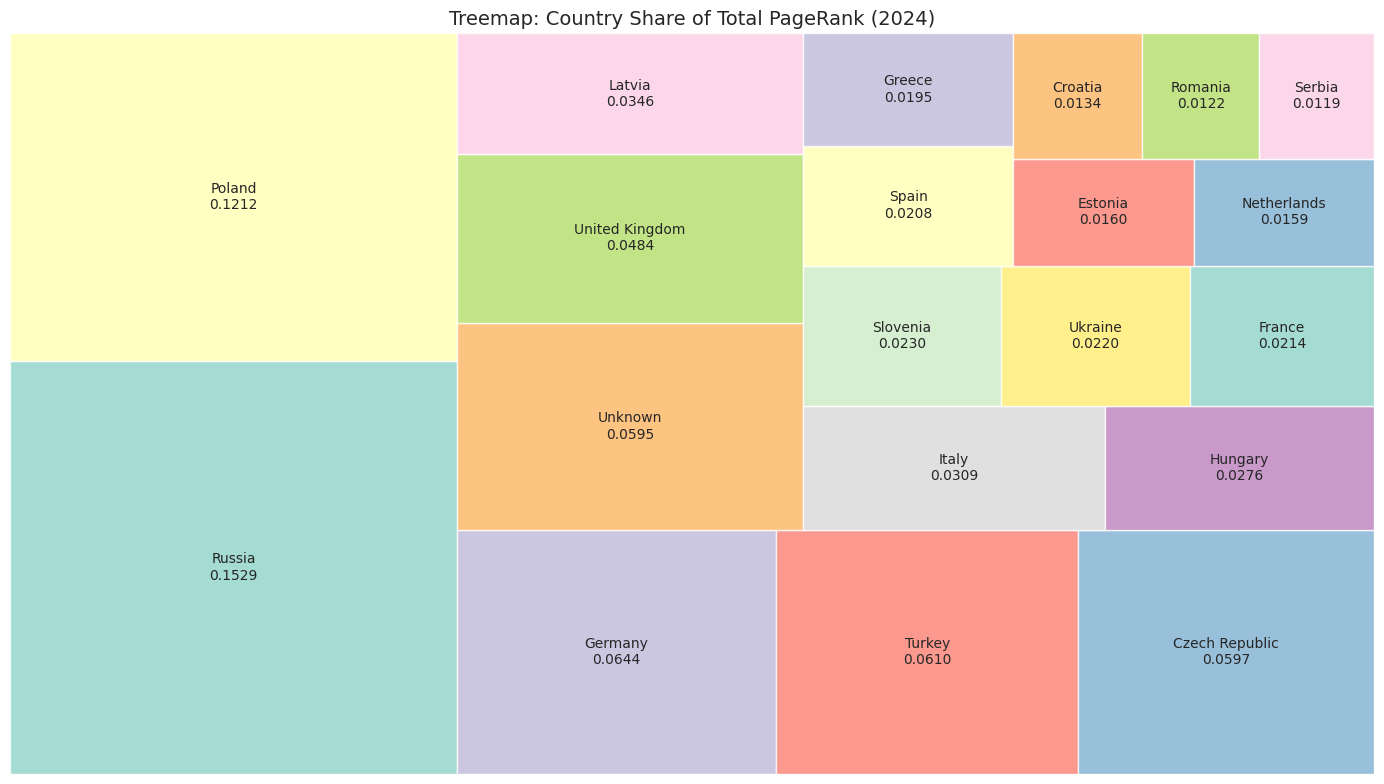

In [20]:
# /// Treemap of PageRank by country
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# Copy PageRank metrics and reset index
df_pr = metrics_2019.copy().reset_index()

# Make sure 'Country' exists; merge only if needed
if 'Country' not in df_pr.columns:
    df_pr = df_pr.merge(airports_raw[['ICAO', 'Country']], left_on='index', right_on='ICAO', how='left')

# Drop entries with no country
df_pr = df_pr[df_pr['Country'].notna()]

# Group by country
country_sums = df_pr.groupby('Country')['PageRank'].sum().sort_values(ascending=False).head(20)

# Plot the treemap
plt.figure(figsize=(14, 8))
squarify.plot(
    sizes=country_sums.values,
    label=[f"{c}\n{v:.4f}" for c, v in zip(country_sums.index, country_sums.values)],
    color=sns.color_palette("Set3", len(country_sums)),
    alpha=0.8,
    text_kwargs={'fontsize': 10}
)

plt.axis('off')
plt.title("Treemap: Country Share of Total PageRank (2024)", fontsize=14)
plt.tight_layout()
plt.show()

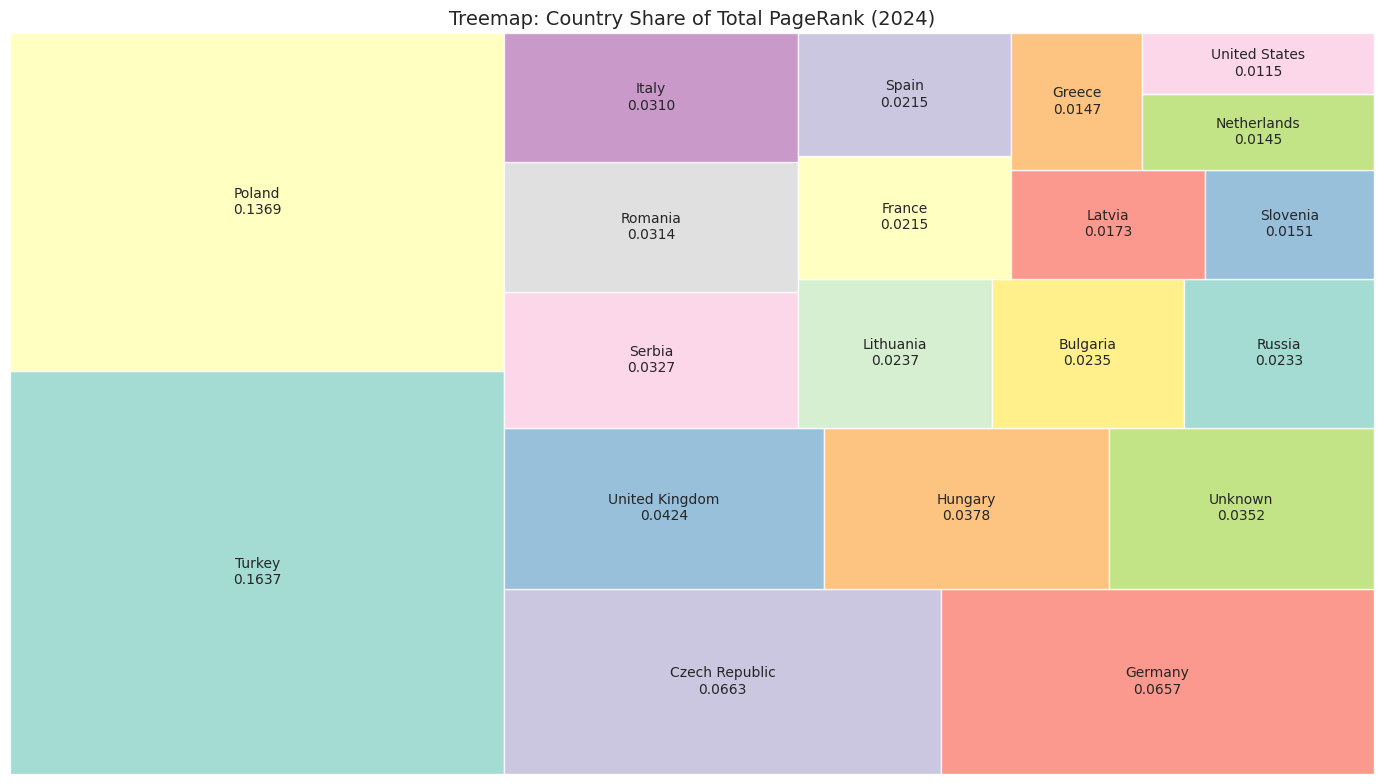

In [19]:
# /// Treemap of PageRank by country
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# Copy PageRank metrics and reset index
df_pr = metrics_2024.copy().reset_index()

# Make sure 'Country' exists; merge only if needed
if 'Country' not in df_pr.columns:
    df_pr = df_pr.merge(airports_raw[['ICAO', 'Country']], left_on='index', right_on='ICAO', how='left')

# Drop entries with no country
df_pr = df_pr[df_pr['Country'].notna()]

# Group by country
country_sums = df_pr.groupby('Country')['PageRank'].sum().sort_values(ascending=False).head(20)

# Plot the treemap
plt.figure(figsize=(14, 8))
squarify.plot(
    sizes=country_sums.values,
    label=[f"{c}\n{v:.4f}" for c, v in zip(country_sums.index, country_sums.values)],
    color=sns.color_palette("Set3", len(country_sums)),
    alpha=0.8,
    text_kwargs={'fontsize': 10}
)

plt.axis('off')
plt.title("Treemap: Country Share of Total PageRank (2024)", fontsize=14)
plt.tight_layout()
plt.show()

# HTML DASHBOARD

In [25]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster
from IPython.display import HTML

# === Create helper map function ===
def get_airport_metadata(icao_code):
    row = airports_raw[airports_raw['ICAO'] == icao_code]
    if not row.empty:
        name = row.iloc[0]['Name']
        country = row.iloc[0]['Country']
        lat = float(row.iloc[0]['Latitude'])
        lon = float(row.iloc[0]['Longitude'])
        return name, country, lat, lon
    return None, None, None, None

def generate_map_with_stats(metrics_df, metrics_df_prev=None):
    fmap = folium.Map(location=[50, 15], zoom_start=4, tiles='cartodbpositron')
    cluster = MarkerCluster().add_to(fmap)

    for icao, row in metrics_df.iterrows():
        name, country, lat, lon = get_airport_metadata(icao)
        if lat is None:
            continue

        # If comparing with 2019
        delta_info = ""
        if metrics_df_prev is not None and icao in metrics_df_prev.index:
            delta_pagerank = row["PageRank"] - metrics_df_prev.loc[icao, "PageRank"]
            delta_info = f"<br><b>Δ PageRank:</b> {delta_pagerank:+.5f}"

        popup_text = (
            f"<b>{icao}</b><br>{name} ({country})"
            f"<br><b>PageRank:</b> {row['PageRank']:.5f}"
            f"<br><b>Betweenness:</b> {row['Betweenness']:.5f}"
            f"<br>InDegree: {row['InDegree']} | OutDegree: {row['OutDegree']}"
            f"{delta_info}"
        )

        folium.CircleMarker(
            location=[lat, lon],
            radius=8 + 80 * row['PageRank'],
            color='darkblue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=folium.Popup(popup_text, max_width=300)
        ).add_to(cluster)

    return fmap

# === Generate maps ===
map_2019 = generate_map_with_stats(metrics_2019)
map_2024 = generate_map_with_stats(metrics_2024, metrics_2019)

# Save maps to HTML fragments
map_2019.save("map_2019.html")
map_2024.save("map_2024.html")

In [26]:
import pandas as pd
import folium

# 1.(ICAO + coordinates)
url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
cols = [
    'AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude',
    'Longitude', 'Altitude', 'Timezone', 'DST', 'TzDatabaseTimeZone',
    'Type', 'Source'
]

airports_raw = pd.read_csv(url, header=None, names=cols)
airports_df = airports_raw[['ICAO', 'Latitude', 'Longitude']].dropna()
airports_df.columns = ['icao', 'lat', 'lon']
airports_df = airports_df[airports_df['icao'].notnull()]
airports_df = airports_df.set_index('icao')

# 2. Visualization function
def plot_routes_on_map(df_routes, airports_df, output_file="routes_map.html"):
    m = folium.Map(location=[50, 15], zoom_start=4, tiles='cartodbpositron')

    for _, row in df_routes.iterrows():
        dep = row['estdepartureairport']
        arr = row['estarrivalairport']
        if dep in airports_df.index and arr in airports_df.index:
            dep_coords = (float(airports_df.loc[dep, 'lat']), float(airports_df.loc[dep, 'lon']))
            arr_coords = (float(airports_df.loc[arr, 'lat']), float(airports_df.loc[arr, 'lon']))
            folium.PolyLine(
                locations=[dep_coords, arr_coords],
                color='blue',
                weight=min(5, 1 + row['flights'] / 100),
                opacity=0.5
            ).add_to(m)

    folium.LayerControl().add_to(m)
    m.save(output_file)
    print(f"✅ Saved map to {output_file}")



plot_routes_on_map(df_2019_regional, airports_df, "routes_2019_full.html")
plot_routes_on_map(df_2024_regional, airports_df, "routes_2024_full.html")
plot_routes_on_map(df_2019_strong, airports_df, "routes_2019_strong.html")
plot_routes_on_map(df_2024_strong, airports_df, "routes_2024_strong.html")

✅ Saved map to routes_2019_full.html
✅ Saved map to routes_2024_full.html
✅ Saved map to routes_2019_strong.html
✅ Saved map to routes_2024_strong.html
